In [1]:
import os
import tarfile
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    response = requests.get(housing_url)
    with open(tgz_path, 'wb') as r:
        r.write(response.content)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()

In [5]:
housing = load_housing_data()

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


There are ten attributes, each being a header in the housing table.

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


info() can be used to show information regarding each column. It shows the type, the number of non-null values in each column, the name of each column.

In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

value_counts() will work on any data type, but it's better used for categorical data. I ran this on the total_bedrooms column which wasn't nearly as useful.

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


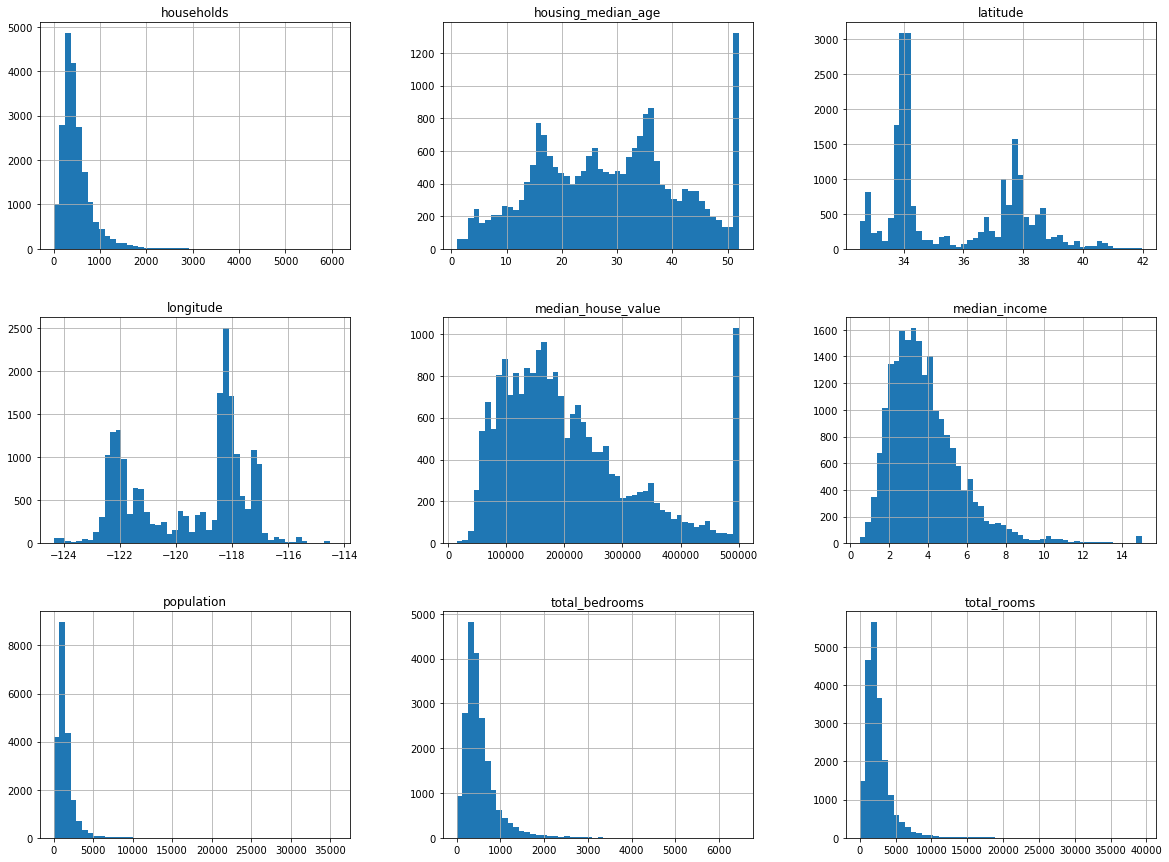

In [11]:
%matplotlib inline
housing.hist(bins=50, figsize=(20, 15))
plt.show()

Something I learned: plt.show() isn't required in Jupyter notebooks as it will automatically render plots.

*data snooping* bias is introducing bias into a machine learning model based on analysis of a test set.

In [12]:
def split_train_test(data, test_ratio):
    """Shuffles then splits the data set into a large training set and small test set."""
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, .2)

Above, random.seed() ensures we get the same permutation of random indeces each time we run this function (so our algorithm doesn't up seeing the whole data set eventually).

The test and train indices are lists of numbers that are indeces of the dataset up to size test_set_size. iloc finds all the data at those indeces in the data set and generates a new dataset based on it. So cool!

Arelien points out that the techniques he suggests will break down when fetching updated data sets. After some experimentation, this is because, even though the data set will contain many of the same items, the random selection will change due to the change in size of the data set. (I saw this for myself by setting a seed then seeing how a list of numbers 1-10 changes as I added numbers.) He then goes on to write a function to that will check the last byte of a hashed version of an instance (row) identifier (id), then adds it to the test set if it wasn't part of the training set. I think I understand what he's trying to accomplish but not the following implementation.

In [13]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    """Returnsa boolean, identifying if a hashed version of column_id is less than 51 (~20% of 256).
    """
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    """Returns """
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

**What's with the trailing underscore after id?**

- The underscore is often used after words that are reserved in python. In this case, id() would give the identify of an object (someone said it is much like a social security number of python objects). As a side note, id() is really only useful in the is operator (since they would have matching ids).

**What's with the fucking tilde?**

- Alright, after some fooling around with the above function, here's what I found...
- It is a unary operator that makes an inverse of an integer. So if you do ~1, you get -2 (not -1, just to be explicit). Numpy has its own flavor of booleans, seen as np.True\_ or np.False\_. , so ~True is False. Again, this is only in Numpy!!!

**What is [-1] doing after the digested hash?**

- So, after some toying around, the size of an md5 hash is 128 bits. There are 8 bits to a byte, so you get 16 bytes is the size of the hash. If you take the len() of the byte string, you will get 16. There is nothing special about the last byte here; it's simply an arbitrary choice among the different bytes available.

**What the hell are these functions doing?**

- It turns out that these two functions are meant to substitute the split_train_test function defined earlier. The issue is that as more data becomes available, the random function will continue to randomize the data because its size is changing. This will end up swapping out test and training set data points. Our goal is to keep them completed isolated from each other, so this won't do. These new functions are essentially an idea of randomizing the data that Arelien came up with. You could choose any hash really, choose any byte in that hash, and use that byte to organize the data into the training and test sets. Since we are applying the test_set_check function to each id, we are guaranteed to get numbers that are less than 20% of 256 over. This divides our data and allows for updating the data without changing the data sets.

*Arelien suggest using lat and long for ids as an alternative, but whatever.*

It turns out sci-kit learn already has a function that does what Aureline defined and more. The following function has a random state for random seeds. I think this will solve the above problem that we used our own hash for.

In [14]:
train_set, test_set = train_test_split(housing, test_size=.2, random_state=42)

*Stratified Sampling*: A population is divided into subgroups that each aim to represent the population as a whole. These are called *strata*. An example would be ensuring a subgroup represents the male and female population percentages 48.7% and 51.3%. Picking 70% women and 30% men would be a poor strata, introducing significant bias.

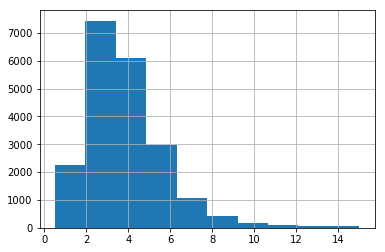

In [15]:
housing['median_income'].hist()

Just a note that the figure provided in the book is a plot of the categories he makes on the following page.

In [16]:
# we have ~15 categories, so we divide by 1.5
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# where allows us to look get any values in the column 
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Alright, I did some research on some things and wanted to take note of what I learned. In the where clause above, we're getting all rows that are less than 5. The second parameter is called *other*, and it's essentially saying *with the rest of the data that I didn't select from the first conditional provided, make them this value*. Then inplace will do it on the column itself rather than making a copy and showing it to you. So, in summary, we're getting all categories less than 5, then making all categories 5.0 or greater 5.

In [17]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

Previously, we randomized our sample and divided it up into a test set and train set. This is fine in most cases, but we need to provide a stratified test and training set since we think median income is a strong indicator of housing prices in an area. 

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.split(housing, housing["income_cat"])
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In the Jupyter notebook that comes with the book, he makes a dataframe showing the percent errors between random sampling and stratifying the data. Less error with stratified data. Now we're going to remove the 'income_cat' column.

In [20]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

In [21]:
housing_train_set = strat_train_set.copy()

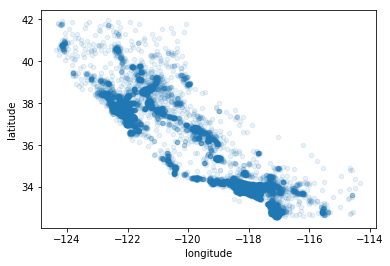

In [22]:
housing_train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Setting the alpha value in the plot makes them more transparent. As dots stack, they become darker, thus highlighting density of certain areas.

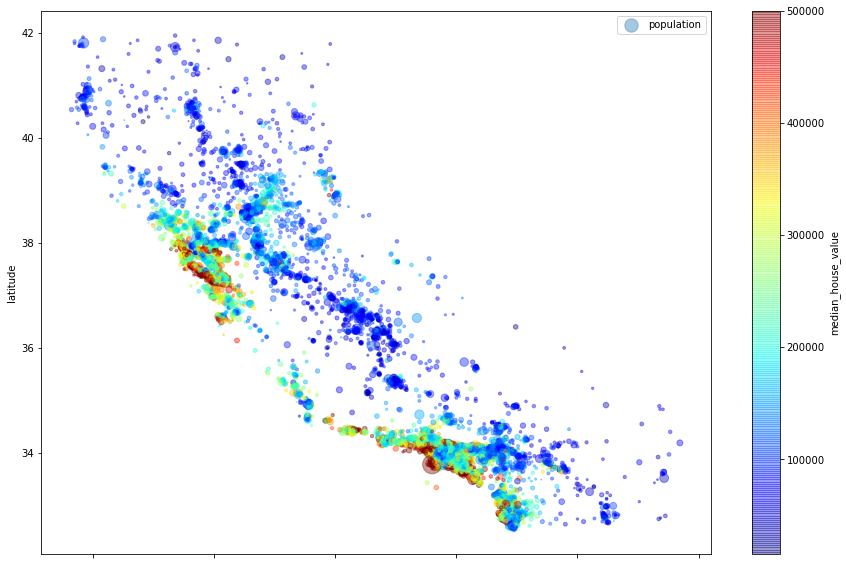

In [23]:
housing_train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                       s=housing["population"]/100, label="population",
                       c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
                       figsize=(15, 10)
                      )
plt.legend()

In [24]:
corr_matrix = housing_train_set.corr()

In [25]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [26]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [1]:
from pandas.plotting import scatter_matrix

In [2]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

NameError: name 'housing' is not defined

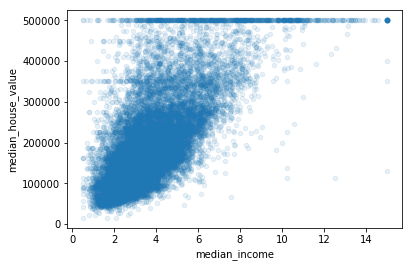

In [29]:
housing_train_set.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [30]:
housing_train_set["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing_train_set["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing_train_set["population_per_household"] = housing["population"]/housing["households"]

In [31]:
corr_matrix = housing_train_set.corr()

In [32]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [33]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

Pandas dataframes have dropna(), drop(), and fillna() methods. Respectively, they should be used to drop certain rows with incomplete data, drop entire columns, or fill missing values with a predetermined value like the median. Apparently sci-kit learn provides an imputer for just this purpose as well.

In [34]:
# housing.dropna(subset=["total_bedrooms"])
# housing.drop("total_bedrooms", axis=1)
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median)

from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [35]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [36]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [37]:
X = imputer.transform(housing_num)

In [38]:
X

array([[ -121.89  ,    37.29  ,    38.    , ...,   710.    ,   339.    ,
            2.7042],
       [ -121.93  ,    37.05  ,    14.    , ...,   306.    ,   113.    ,
            6.4214],
       [ -117.2   ,    32.77  ,    31.    , ...,   936.    ,   462.    ,
            2.8621],
       ..., 
       [ -116.4   ,    34.09  ,     9.    , ...,  2098.    ,   765.    ,
            3.2723],
       [ -118.01  ,    33.82  ,    31.    , ...,  1356.    ,   356.    ,
            4.0625],
       [ -122.45  ,    37.77  ,    52.    , ...,  1269.    ,   639.    ,
            3.575 ]])

the fit_transform() method will perform both of the fit() and transform() methods at once

In [39]:
Y = imputer.fit_transform(housing_num)

In [40]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [41]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [42]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)

In [43]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The pandas docs says that the Series.reshape() will eventually be replaced by Series.values.reshape. I tried it in the cell above. The housing_cat_1hot is a numpy array, not a series.

In [44]:
rando = np.arange(6).reshape(3,2)

In [45]:
rando.reshape(-1, 1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

In [46]:
rando

array([[0, 1],
       [2, 3],
       [4, 5]])

In [47]:
rando.reshape(6, 1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

In [48]:
rando.reshape(-1,1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

In [49]:
rando.reshape(-1, 1).reshape(3, -1)

array([[0, 1],
       [2, 3],
       [4, 5]])

In [50]:
rando1 = rando.reshape(-1, 1)

In [51]:
rando1

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

In [52]:
rando1.reshape(3, -1)

array([[0, 1],
       [2, 3],
       [4, 5]])

In [53]:
# housing_cat_1hot.toarray()

The sparse matrix will store the location of each value in, since storing a whole bunch of 0s and 1s would be very wasteful.

Also, the transformation from categorical data to binary data, to one-vectors can be done using LabelBinarizer

In [54]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [55]:
# use sparse_output=True to get a sparse matrix

We need to make a custom transformation in order to add some needed information. The TransformerMixin will supply the fit_transform method. The BaseEstimator is the Estimator base class and is the core class.

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do here
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

It's important to note here that scikit-learn does not use or interact with pandas DataFrames. It works directly with numpy's ndarrays, so that is why we had to use the above notation to perform the transform function. Other packages can be installed to add classes that will allow sklearn to interact with dataframes.

In [57]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ..., 
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [58]:
testy = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]})

In [59]:
testy

,A,B,C
0,1,4,7
1,2,5,8
2,3,6,9


In [60]:
print(list(testy))

['A', 'B', 'C']


In [61]:
newy = np.c_[testy.values, np.array([10, 11, 12])]

In [62]:
newy

array([[ 1,  4,  7, 10],
       [ 2,  5,  8, 11],
       [ 3,  6,  9, 12]], dtype=int64)

Aurelien states that machine learning algorithms don't perform well when numerical attributes have very different scales. So we have to do some *feature scaling*. We can either do *min-max scaling* (the most common method of normalization) or *standardization*.

Standardization is the standard score, and will measure the attributes based on their signed standard deviations from the mean.

$$ z = \frac{x - \mu}{\sigma}$$ 

Normalization changes values to a 0-1 scale. The value minus the min, divided by the range yields this value.

$$ z =  \frac{x - x_{min}}{x_{max} - x_{min}}$$

Each pose advantages and disadvantages. Some machine algorithms don't like that standardization does not bound values from 0-1, but it is less affected by outliers. 

Sklearn provides pipelines that allow you to pass in the information and performs all of the above steps in the correct order. 

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

But we also have a labelbinarizer to apply. Sklearn provides a FeatureUnion class for this. But since sklearn doesn't interact with dataframes, we need to pass a custom transformer into the pipelines to turn our dfs to np arrays.

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes_names].values

Now we can use featureunion to combine the two pipelines.

In [65]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [66]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [68]:
housing_labels.iloc[:5]

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [69]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

#### What we did here

We instantiated a sci-kit learn LinearRegression class and fit a linear regression model to our prepared housing data. Then we took a chunk of the training set and used our model to predict median house values based on the values that we passed in. I'm still trying to grasp what scikit learn is doing because we have a lot of attributes to fit to a model. The more I think about this, the more I realize I'm used to seeing only one linear regression model fit for a single independent variable. In this case, we have multiple indepedent variables, but we are still getting one single prediction of the median housing value.

Derp. Multiple regression! Just to reiterate my learning, the formula looks pretty simple:

#### $$\hat{y} = a + b_1X_1 + b_2X_2 + ... + b_nX_n + e$$
y = prediction value
a = y-intercept
b = slope of line
x = independent variable
e = error

The model isn't super accurate. Aurelien then shows us the inaccuracy using the root mean squared error, or the average error between our test set and the predicted values from the training set. This looks very similar to the equation to calculate standard deviation, but it has a different meaning/value in this context.

#### $$ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\hat{x}_i - x)^2}$$

To reduce our RMSE we can try three things:

- **Use a different, more powerful model**
- **Feed the training algorithm better data with better features**
- **Reduce constraints on the model**

Next we'll try a decision tree.

In [70]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [71]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Well, this overfit the data pretty badly.

In [72]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [73]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [ 69316.02634772  65498.84994772  71404.25935862  69098.46240168
  70580.30735263  75540.88413124  69717.93143674  70428.42648461
  75888.17618283  68976.12268448]
Mean: 70644.9446328
Standard deviation: 2938.93789263


In [74]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


In [75]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22252.738943108321

In [76]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52869.23106834  49189.93801195  51726.73647871  54995.98190463
  50979.93079904  55978.43765914  52283.7609046   51001.92227546
  54447.35786983  53389.94422283]
Mean: 52686.3241195
Standard deviation: 1971.26547795


For some reason my numbers are pretty different from Aurelien's, but they are still following the same trends. Of the three models we've tried, random forests have performed the best. The data is still overfitted, so we're going to continue exploring ways to improve our model. In the meantime, we'd like to save our model so we don't have to retrain it again. Python's Pickle module can be used to do this. From what I understand, pickling will save a Python object on disk so it can be used later. I think this is saving the object directly on disk rather than a text file that contains the code representing the object. Sklearn contains its own version of pickling called joblib that is more efficient at serializing large NumPy arrays. 

In [77]:
from sklearn.externals import joblib

joblib.dump(forest_reg, "forest_model.pkl")
joblib.dump(tree_reg, "tree_model.pkl")
joblib.dump(lin_reg, "linear_model.pkl")

# loaded_model = joblib.load("forest_model.pkl")

['linear_model.pkl']

So we need to start tuning hyper parameters to really lock in our model. I don't think we've directly meddled with hyperparameters yet, so we're going to get sklearn to search for the best hyperparameter values for us. I tried to gain some clarity on the following code, but after reading ahead, Aurelien suggests not diving into it until Chapter 7.

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [79]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [80]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [81]:
cvres = grid_search.cv_results_

In [82]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64583.2383134 {'max_features': 2, 'n_estimators': 3}
55503.6078699 {'max_features': 2, 'n_estimators': 10}
52949.1294934 {'max_features': 2, 'n_estimators': 30}
60717.6157768 {'max_features': 4, 'n_estimators': 3}
52634.1052674 {'max_features': 4, 'n_estimators': 10}
50528.7451101 {'max_features': 4, 'n_estimators': 30}
58493.2146791 {'max_features': 6, 'n_estimators': 3}
52208.3486668 {'max_features': 6, 'n_estimators': 10}
49924.8890318 {'max_features': 6, 'n_estimators': 30}
58650.6191468 {'max_features': 8, 'n_estimators': 3}
52369.1878452 {'max_features': 8, 'n_estimators': 10}
50109.8456878 {'max_features': 8, 'n_estimators': 30}
62626.1667289 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54498.8454323 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60353.8008531 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52397.6755216 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
59152.2214146 {'bootstrap': False, 'max_features': 4, 'n_estim

Here we can see how the grid_search made its determination. The lowest RMSE is 49924 where max_features = 6 and estimators are 30.

In [83]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.69687766e-02,   7.04319887e-02,   4.38660619e-02,
         1.80630448e-02,   1.66508742e-02,   1.79482850e-02,
         1.59942989e-02,   3.27548930e-01,   5.57736006e-02,
         1.05319561e-01,   9.13965806e-02,   1.16638033e-02,
         1.38350194e-01,   1.03976446e-04,   3.83940095e-03,
         6.08062375e-03])

In [84]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32754893001195934, 'median_income'),
 (0.13835019350471953, 'INLAND'),
 (0.10531956070724346, 'pop_per_hhold'),
 (0.09139658055040592, 'bedrooms_per_room'),
 (0.076968776639663436, 'longitude'),
 (0.07043198869339834, 'latitude'),
 (0.05577360056115168, 'rooms_per_hhold'),
 (0.043866061924543169, 'housing_median_age'),
 (0.018063044805051474, 'total_rooms'),
 (0.01794828495917463, 'population'),
 (0.016650874220719983, 'total_bedrooms'),
 (0.015994298942109429, 'households'),
 (0.01166380333543238, '<1H OCEAN'),
 (0.0060806237459764172, 'NEAR OCEAN'),
 (0.0038394009525752962, 'NEAR BAY'),
 (0.0001039764458754885, 'ISLAND')]

In [85]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47547.546074098922

In [87]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)
predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, predictions)
svm_rmse = np.sqrt(svm_mse)

param_grid = [
    {'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
     'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 11.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [92]:
svm_grid_rmse = np.sqrt(-grid_search.best_score_)
svm_grid_rmse

70363.903139641669

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

Rnao